In [1]:
import torch
import numpy as np 
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from training import *
from mlxtend.data import mnist_data
from accuracy_compute import *
from data_preparation_easy import *
from data_preparation_hard import *
from network_func import *
from search_parameter import *
import optuna
from CIFAR10_model import *
from CIFAR10_data_preparation import *

In [4]:
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=cifar10_prepare_node_5_hard_shuffled()

A的第二大特征值: 0.7360318786212677
A的beta: 0.810217360924142
A的spectral gap: 0.18978263907585802
A的kappa: 2.000000000000005
S_A是: 39.898193112709905 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 50/50 [15:18<00:00, 18.38s/it, epoch=50, loss=0.0001346993, test_accuracy=66.3700000000%, trian_accuracy=99.9700000000%]


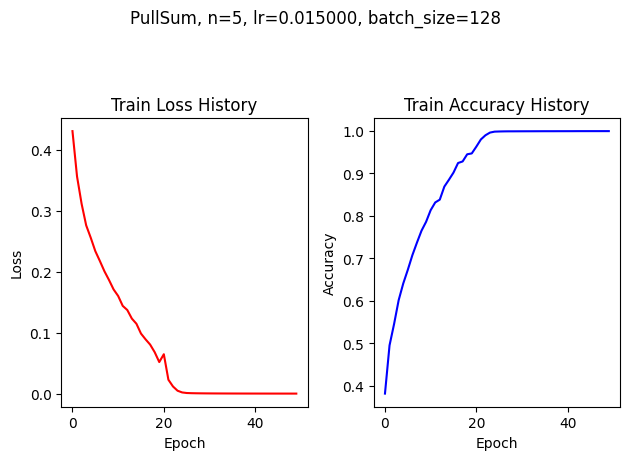

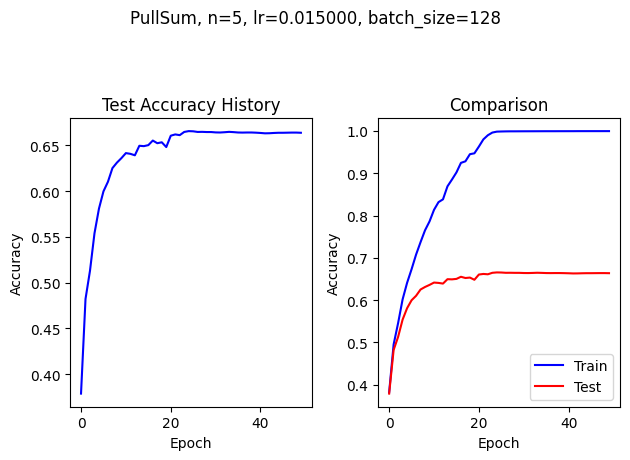

In [10]:
from torchvision.models import resnet18
model_class = lambda: resnet18(num_classes=10)

Sum_l1, Sum_a1 = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=model_class,#SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=50,
    lr=3e-3,
    batch_size=128,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model_resnet18,
    show_graph=True
)

In [2]:
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=cifar10_prepare_node_5_hard_shuffled(augment=True)

A的第二大特征值: 0.7360318786212677
A的beta: 0.810217360924142
A的spectral gap: 0.18978263907585802
A的kappa: 2.000000000000005
S_A是: 39.898193112709905 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 50/50 [15:16<00:00, 18.34s/it, epoch=50, loss=0.0001703498, test_accuracy=62.1700000000%, trian_accuracy=99.9800000000%]


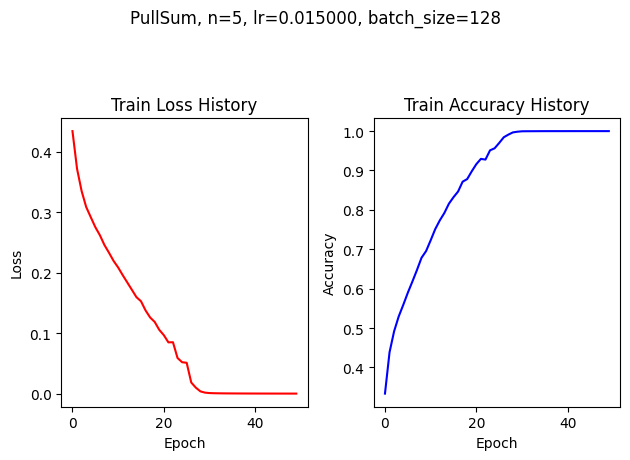

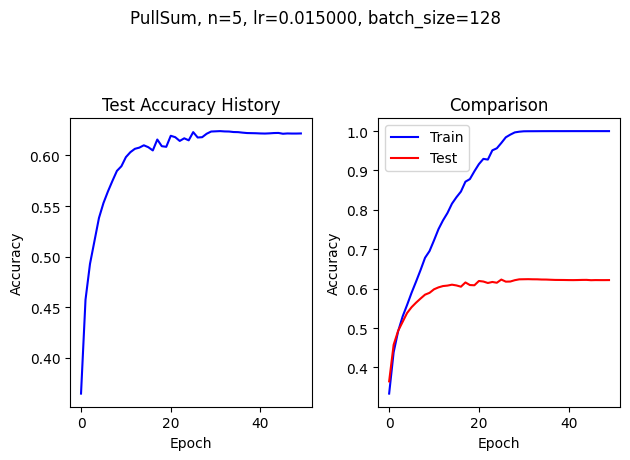

In [3]:
# 数据增强之后正确率反而更低了？
from torchvision.models import resnet18
model_class = lambda: resnet18(num_classes=10)

Sum_l1, Sum_a1 = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=model_class,#SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=50,
    lr=3e-3,
    batch_size=128,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model_resnet18,
    show_graph=True
)

In [4]:
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=cifar10_prepare_node_5_hard_shuffled(augment=False)

A的第二大特征值: 0.7360318786212677
A的beta: 0.810217360924142
A的spectral gap: 0.18978263907585802
A的kappa: 2.000000000000005
S_A是: 39.898193112709905 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 10/10 [05:57<00:00, 35.74s/it, epoch=10, loss=0.1309286270, test_accuracy=65.8100000000%, trian_accuracy=84.7640000000%]


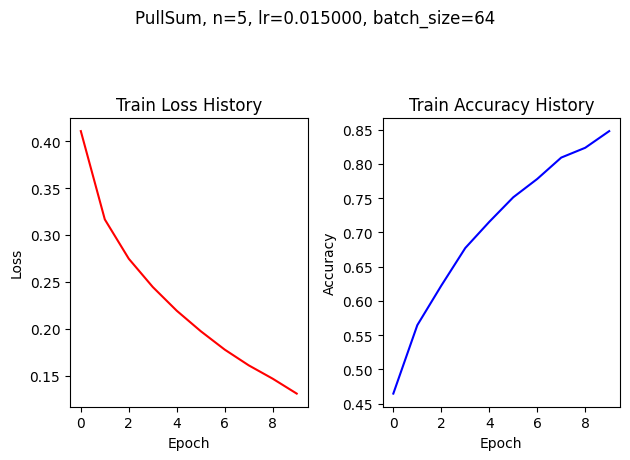

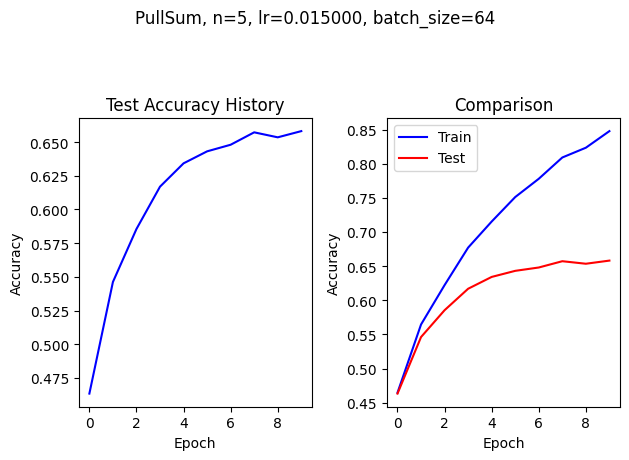

In [5]:
# 更小的batch_size, 差别不大?
from torchvision.models import resnet18
model_class = lambda: resnet18(num_classes=10)

Sum_l1, Sum_a1 = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=model_class,#SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=10,
    lr=3e-3,
    batch_size=64,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model_resnet18,
    show_graph=True
)

In [4]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()  # 将模型设置为训练模式
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算训练损失和准确性
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f"Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# 测试循环
def test(model, device, test_loader, criterion):
    model.eval()  # 将模型设置为评估模式
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 在测试过程中不计算梯度
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # 计算准确性
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设已经加载了 CIFAR-10 数据并准备好训练和测试数据
X_train, X_test, y_train, y_test = load_cifar10_data()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将数据转换为 Tensor 并移动到设备 (GPU 或 CPU)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# 定义模型、损失函数和优化器
model = resnet18(num_classes=10).to(device)#SimpleResNet1().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# 假设已经定义了批量大小
batch_size = 128

# 创建数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 训练循环
num_epochs = 50

# 运行训练和测试循环
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)

Epoch [1/50]
Train Loss: 2.0910, Accuracy: 23.87%
Test Loss: 1.8570, Accuracy: 33.17%
Epoch [2/50]
Train Loss: 1.7434, Accuracy: 36.58%
Test Loss: 1.6613, Accuracy: 39.36%
Epoch [3/50]
Train Loss: 1.5798, Accuracy: 42.55%
Test Loss: 1.5583, Accuracy: 42.97%
Epoch [4/50]
Train Loss: 1.4816, Accuracy: 46.33%
Test Loss: 1.4958, Accuracy: 45.65%
Epoch [5/50]
Train Loss: 1.4017, Accuracy: 49.35%
Test Loss: 1.4512, Accuracy: 47.22%
Epoch [6/50]
Train Loss: 1.3370, Accuracy: 51.90%
Test Loss: 1.4158, Accuracy: 48.50%
Epoch [7/50]
Train Loss: 1.2851, Accuracy: 54.03%
Test Loss: 1.3926, Accuracy: 49.19%
Epoch [8/50]
Train Loss: 1.2351, Accuracy: 55.86%
Test Loss: 1.3826, Accuracy: 49.82%
Epoch [9/50]
Train Loss: 1.1914, Accuracy: 57.59%
Test Loss: 1.3633, Accuracy: 50.65%
Epoch [10/50]
Train Loss: 1.1447, Accuracy: 59.36%
Test Loss: 1.3491, Accuracy: 51.11%
Epoch [11/50]
Train Loss: 1.1035, Accuracy: 61.10%
Test Loss: 1.3411, Accuracy: 51.76%
Epoch [12/50]
Train Loss: 1.0624, Accuracy: 62.56%
T